In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (train_test_split, cross_val_score, KFold)
from sklearn.linear_model import (LinearRegression, LassoCV, RidgeCV)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#### The new version of the massaged, web-scraped file contains interaction terms (weight + 3*height and age + 5*experience).  
- 3 & 5 were chosen so the values would be roughly equally waited with their counterparts, based on average ratios between the two.

In [22]:
df = pd.read_excel('baseball_data_5.xlsx')

In [23]:
#df.head()

#### After modeling with all_df, the same techniques will be applied to the batting & pitching subsets.

In [24]:
all_df = df[["Year",
"Team",
"Win_Loss_Per",
"Total_Adj_Team_Salary",
"Average_Team_Age",
"Average_Years_Play",
"Average_Team_Height",
"Average_Team_Weight",
"All_HW",
"All_AE"]]

In [25]:
bat_df = df[["Year",
"Team",
"Win_Loss_Per",
"Total_Adj_Batting_Salary",
"Average_Batting_Age",
"Average_Years_Batting",
"Average_Height_of_Batter",
"Average_Weight_of_Batter",
"Bat_HW",
"Bat_AE"]]

In [26]:
pitch_df = df[["Year",
"Team",
"Win_Loss_Per",
"Total_Adj_Pitching_Salary",
"Average_Pitching_Age",
"Average_Years_Pitching",
"Average_Height_of_Pitcher",
"Average_Weight_of_Pitcher",
"Pitch_HW",
"Pitch_AE"]]

- The first few Linear Regression models will compare unregularized data with and without the 2 interaction terms respectively. 
- statsmodels' OLS will be used to easily analyze coefficients & p-values. Cross-validation will be applied as well to determine which is overfitting.
- Later we will standardize the data with lasso & ridge to see which performs better.
- The models will then be applied to the batting & pitching subsets to see if they are better for one over the other.

#### Separating out dependent and target variables for all_df:

In [27]:
x1 = all_df.drop(columns=["Win_Loss_Per","Year","Team",
                          "All_HW",
                          "All_AE"])
y1 = all_df["Win_Loss_Per"]
#---------------------
x2 = all_df.drop(columns=["Win_Loss_Per","Year","Team"])
y2 = all_df["Win_Loss_Per"]
#---------------------

-----

#### Splitting both all_df sets into train vs test:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x1,y1,test_size=.3,random_state=43)

In [29]:
X_inter, X_inter_test, y_inter, y_inter_test = train_test_split(x2,y2,test_size=.3,random_state=43)

---

## Various Linear Regression Models on Combined Pitching + Batting Data

In [30]:
lr = LinearRegression()
lr_1 = lr.fit(X_train,y_train)
print(cross_val_score(lr_1,X_train,y_train,scoring = 'r2'))
a=cross_val_score(lr_1,X_test,y_test,scoring = 'r2')
print(a.mean())

[0.1954899  0.22704567 0.05867808 0.2211289  0.15064558]
0.23661251506271713


In [31]:
list(zip(X_train.columns, lr_1.coef_))

[('Total_Adj_Team_Salary', 1.9809754781972654e-09),
 ('Average_Team_Age', -0.03942569876795443),
 ('Average_Years_Play', 0.13805821570564827),
 ('Average_Team_Height', 0.0018917084355479996),
 ('Average_Team_Weight', -0.001374179749303782)]

In [32]:
lr_1_pred = lr_1.predict(X_test)
print(f'RMSE: {sqrt(mean_squared_error(y_test, lr_1_pred))}')
print(f'MAE: {mean_absolute_error(y_test, lr_1_pred)}')

RMSE: 0.24532832884071007
MAE: 0.19560379050921628


--------

##### Simple Linear Regression with feature engineered all_df

In [93]:
lr_2 = lr.fit(X_inter,y_inter)
print(cross_val_score(lr_2,X_inter,y_inter,scoring = 'r2'))
b = cross_val_score(lr_2,X_inter_test,y_inter_test,scoring = 'r2')
print(b.mean())

[0.1954899  0.22704567 0.05867808 0.2211289  0.15064558]
0.23661251506271724


In [96]:
list(zip(X_inter.columns, lr_2.coef_))

[('Total_Adj_Team_Salary', 1.9809754781972252e-09),
 ('Average_Team_Age', -0.06353182394426136),
 ('Average_Years_Play', 0.017527589824113635),
 ('Average_Team_Height', 0.0007187232835462094),
 ('Average_Team_Weight', -0.0017651747999712503),
 ('All_HW', 0.00039099505066746143),
 ('All_AE', 0.024106125176306937)]

In [36]:
lr_2_pred = lr_2.predict(X_inter_test)
print(f'RMSE: {sqrt(mean_squared_error(y_inter_test, lr_2_pred))}')
print(f'MAE: {mean_absolute_error(y_inter_test, lr_2_pred)}')

RMSE: 0.24532832884071007
MAE: 0.1956037905092163


#### Performance did not differ between the two models, but there is some interesting information about R-squared & the coefficients. Standardization will be introduced next to account for the scaling of the dependent variables' units .

## Standardization

In [39]:
std_1 = StandardScaler()
X_sc = std_1.fit_transform(X_train) #creates the scale
kf = KFold(n_splits=5, shuffle=True, random_state = 3)
alphas = 10**np.linspace(-2,2,200)

### Lasso Models

In [92]:
lasso_1 = LassoCV(alphas=alphas,cv=kf)
lasso_1.fit(X_train,y_train)
lasso_1.score(X_test,y_test), lasso_1.score(X_train,y_train)

(0.24272821977050618, 0.187070030015563)

In [47]:
list(zip(X_train.columns,lasso_1.coef_))

[('Total_Adj_Team_Salary', 1.7289106926967994e-09),
 ('Average_Team_Age', -0.003280300358971341),
 ('Average_Years_Play', 0.09609552906745263),
 ('Average_Team_Height', 0.0),
 ('Average_Team_Weight', -0.0013656528117928087)]

In [43]:
lasso_pred = lasso_1.predict(X_test)
print(f'RMSE: {sqrt(mean_squared_error(y_test, lasso_pred))}')
print(f'MAE: {mean_absolute_error(y_test, lasso_pred)}')

RMSE: 0.24803421944631027
MAE: 0.19578546781180045


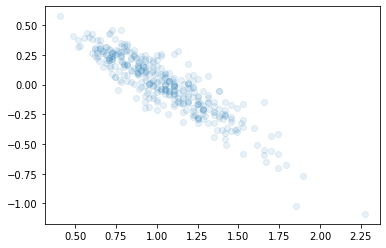

In [45]:
lasso_resid = lasso_pred - y_test
plt.scatter(y_test,lasso_resid, alpha=0.1)

##### Testing model on FE set

In [91]:
#lasso_2 = LassoCV(alphas=alphas,cv=kf)
#lasso_2.fit(X_inter,y_inter)
print(lasso_2.score(X_inter_test,y_inter_test),lasso_2.score(X_inter,y_inter))
#lasso_pred_2 = lasso_2.predict(X_inter_test)
print(f'RMSE: {sqrt(mean_squared_error(y_inter_test, lasso_pred_2))}')
print(f'MAE: {mean_absolute_error(y_inter_test, lasso_pred_2)}')

0.24839874449202892 0.19140225078981576
RMSE: 0.2471038222713064
MAE: 0.1956647703577241


In [49]:
list(zip(X_inter.columns,lasso_2.coef_))

[('Total_Adj_Team_Salary', 1.7215723946515614e-09),
 ('Average_Team_Age', -0.03528978758153537),
 ('Average_Years_Play', 0.0),
 ('Average_Team_Height', -0.0),
 ('Average_Team_Weight', -0.0009786972362910114),
 ('All_HW', -1.7181614458658407e-05),
 ('All_AE', 0.022412602374611502)]

### Ridge models

In [53]:
#ridge_1 = RidgeCV(alphas=alphas,cv=kf)
#ridge_1.fit(X_train,y_train)
#ridge_1.score(X_test,y_test), ridge_1.score(X_train,y_train)

The results of the cell above are pasted below because the return requires a lot of scrolling.

(0.2583865749670099, 0.19520788099397723)

In [54]:
list(zip(X_train.columns, ridge_1.coef_))

[('Total_Adj_Team_Salary', 1.9715968349018817e-09),
 ('Average_Team_Age', -0.035148719956728004),
 ('Average_Years_Play', 0.13185190522975834),
 ('Average_Team_Height', 0.0018724266462222313),
 ('Average_Team_Weight', -0.0014774937722552535)]

In [55]:
ridge_1_pred = ridge_1.predict(X_test)
print(f'RMSE: {sqrt(mean_squared_error(y_test, ridge_1_pred))}')
print(f'MAE: {mean_absolute_error(y_test, ridge_1_pred)}')

RMSE: 0.24545648250355673
MAE: 0.19555858177941277


Text(0.5, 0, 'Residuals')

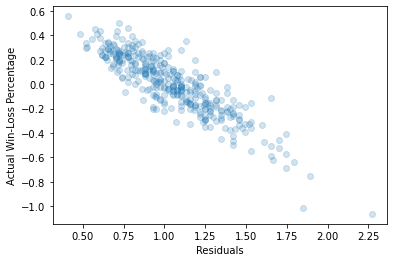

In [57]:
ridge_1_resid = ridge_1_pred - y_test
plt.scatter(y_test,ridge_1_resid,alpha=0.2)
plt.ylabel("Actual Win-Loss Percentage")
plt.xlabel("Residuals")

#### Ridge 1 trained on all teammates (B+P) is best model, though it has the same issue as the others: a strong linear relationship in the plotted residuals. 

##### According to Stack Exchange, a "slanted" residual plot typically results from the influence of a few VERY influential and VERY leveraging observations (aka outliers). 
- LOESS or LOWESS smoothing only works when your dependent variable is a vector.
- Therefore the next attempt will be removing outliers.

In [145]:
new_all_df = all_df[(np.abs(stats.zscore(all_df["Total_Adj_Team_Salary"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["Average_Team_Age"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["Average_Years_Play"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["Average_Team_Height"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["Average_Team_Weight"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["All_HW"])) < 2)]
new_all_df = new_all_df[(np.abs(stats.zscore(new_all_df["All_AE"])) < 2)]

In [146]:
new_all_df.shape

(928, 10)

In [147]:
new_df = new_all_df.drop(columns=["All_HW","All_AE"])

In [148]:
xn1 = new_df.drop(columns=["Win_Loss_Per","Year","Team"])
yn1 = new_df["Win_Loss_Per"]

xn2= new_all_df.drop(columns=["Win_Loss_Per","Year","Team"])
yn2 = new_all_df["Win_Loss_Per"]

In [149]:
Xn1_train, Xn1_test, yn1_train, yn1_test = train_test_split(xn1,yn1,test_size=.3,random_state=43)
Xn2_train, Xn2_test, yn2_train, yn2_test = train_test_split(xn2,yn2,test_size=.3,random_state=43)

In [152]:
#new_ridge_1 = RidgeCV(alphas=alphas,cv=kf)
#new_ridge_1.fit(Xn1_train,yn1_train)
#new_ridge_1.score(Xn1_test,yn1_test), new_ridge_1.score(Xn1_train,yn1_train)
#RESULTS:
#WHILE Z.SCORE < 3: (0.21330859500519805, 0.18726005368875698)
#WHEN Z.SCORE <2: (0.12561007329870488, 0.17225026011735978)

In [139]:
list(zip(Xn1_train.columns, new_ridge_1.coef_))

[('Total_Adj_Team_Salary', 2.4063040401348652e-09),
 ('Average_Team_Age', -0.031230181154373753),
 ('Average_Years_Play', 0.12088365098118152),
 ('Average_Team_Height', 0.0015253486453533371),
 ('Average_Team_Weight', -0.0026169666497027474)]

In [140]:
new_ridge_1_pred = new_ridge_1.predict(Xn1_test)
print(f'RMSE: {sqrt(mean_squared_error(yn1_test, new_ridge_1_pred))}')
print(f'MAE: {mean_absolute_error(yn1_test, new_ridge_1_pred)}')

RMSE: 0.25233824205909683
MAE: 0.20080598921981344


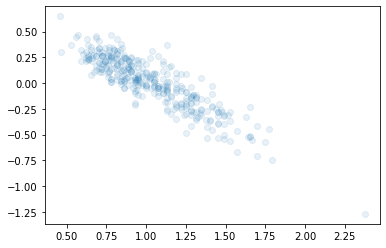

In [142]:
new_ridge_1_resid = new_ridge_1_pred - yn1_test
plt.scatter(yn1_test,new_ridge_1_resid,alpha=0.1)

In [ ]:
new_ridge_2 = 

In [130]:
new_all_df.columns

Index(['Year', 'Team', 'Win_Loss_Per', 'Total_Adj_Team_Salary',
       'Average_Team_Age', 'Average_Years_Play', 'Average_Team_Height',
       'Average_Team_Weight', 'All_HW', 'All_AE'],
      dtype='object')

In [129]:
new_all_df.shape

(1156, 10)

In [106]:
all_df.head()

,Year,Team,Win_Loss_Per,Total_Adj_Team_Salary,Average_Team_Age,Average_Years_Play,Average_Team_Height,Average_Team_Weight,All_HW,All_AE
0,1980,ATL,1.012500,6.123001e+06,27.733333,6.325758,72.688312,184.950216,403.015152,59.362121
1,1980,CHC,0.653061,2.773667e+06,28.600000,5.516340,73.712121,191.458333,412.594697,56.181699
2,1980,KCR,1.492308,2.443967e+06,28.266667,6.087087,73.042424,185.651515,404.778788,58.702102
3,1980,NYY,1.745763,1.100086e+07,30.400000,9.068376,73.000000,183.461538,402.461538,75.741880
4,1980,SDP,0.820225,4.516368e+06,28.200000,6.033333,73.119048,185.390476,404.747619,58.366667


In [109]:
all_df.iloc[0,4]
#Columns labeled 3-9 should be standardized

27.7333333333333

In [125]:
all_df.head()

,Year,Team,Win_Loss_Per,Total_Adj_Team_Salary,Average_Team_Age,Average_Years_Play,Average_Team_Height,Average_Team_Weight,All_HW,All_AE
0,1980,ATL,1.012500,6.123001e+06,27.733333,6.325758,72.688312,184.950216,403.015152,59.362121
1,1980,CHC,0.653061,2.773667e+06,28.600000,5.516340,73.712121,191.458333,412.594697,56.181699
2,1980,KCR,1.492308,2.443967e+06,28.266667,6.087087,73.042424,185.651515,404.778788,58.702102
3,1980,NYY,1.745763,1.100086e+07,30.400000,9.068376,73.000000,183.461538,402.461538,75.741880
4,1980,SDP,0.820225,4.516368e+06,28.200000,6.033333,73.119048,185.390476,404.747619,58.366667


In [99]:
#ridge_2 = RidgeCV(alphas=alphas,cv=kf)
#ridge_2.fit(X_inter,y_inter)
#ridge_2.score(X_inter_test,y_inter_test), ridge_2.score(X_inter,y_inter)
#RESULTS PASTED BELOW
(0.25821634156341455, 0.19528372788861204)

(0.25821634156341455, 0.19528372788861204)

In [100]:
list(zip(X_inter.columns, ridge_2.coef_))

[('Total_Adj_Team_Salary', 1.9466612126752313e-09),
 ('Average_Team_Age', -0.059175599297586465),
 ('Average_Years_Play', 0.016548347455665177),
 ('Average_Team_Height', 0.0006652952384199631),
 ('Average_Team_Weight', -0.0016674062881950917),
 ('All_HW', 0.00032847942705718254),
 ('All_AE', 0.023566137980763027)]

-----

## Creating training and testing distinct subsets of pitch_df and bat_df for model application

### Batting Dataframe

In [58]:
bx1 = bat_df.drop(columns=["Win_Loss_Per","Year","Team",
                          "Bat_HW",
                          "Bat_AE"])
by1 = bat_df["Win_Loss_Per"]
#---------------------
bx2 = bat_df.drop(columns=["Win_Loss_Per","Year","Team"])
by2 = bat_df["Win_Loss_Per"]
#---------------------

In [63]:
#Checking how overall data models perform on these datasets
#print(lasso_1.score(bx1,by1)) #Calling original LassoCV model
#print(lasso_2.score(bx2,by2)) #Performed slightly better with feature engineering, but worse than all_df
#RESULTS ARE:
#0.1712195833407837
#0.17637400646675838

#### Create new training & testing models for subsets

In [65]:
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(bx1,by1,test_size=.3,random_state=43)
Xb2_inter, Xb2_inter_test, yb2_inter, yb2_inter_test = train_test_split(bx2,by2,test_size=.3,random_state=43)

##### Fitting a ridge model to the batting data returned similar test results to the overall dataframe.

In [71]:
#ridge_b1 = RidgeCV(alphas=alphas,cv=kf)
#ridge_b1.fit(Xb1_train,yb1_train)
#ridge_b1.score(Xb1_test,yb1_test), ridge_b1.score(Xb1_train,yb1_train)
#RESULTS PASTED BELOW; RETURN MESSAGE VERY LONG
(0.25505635033214047, 0.18987388634708258)

(0.25505635033214047, 0.18987388634708258)

In [80]:
list(zip(Xb1_train.columns, ridge_b1.coef_))

[('Total_Adj_Batting_Salary', 1.3966170522490246e-09),
 ('Average_Batting_Age', -0.03377850950529163),
 ('Average_Years_Batting', 0.13517872395894986),
 ('Average_Height_of_Batter', 0.0017385133379004588),
 ('Average_Weight_of_Batter', -0.00018027017868598428)]

In [86]:
ridge_b1_pred = ridge_b1.predict(Xb1_test)
print(f'RMSE: {sqrt(mean_squared_error(yb1_test, ridge_b1_pred))}')
print(f'MAE: {mean_absolute_error(yb1_test, ridge_b1_pred)}')

RMSE: 0.24600697794178913
MAE: 0.19529289324092364


##### Ridge model on batting team with feature engineering.

In [73]:
#ridge_b2 = RidgeCV(alphas=alphas,cv=kf)
#ridge_b2.fit(Xb2_inter,yb2_inter)
#ridge_b2.score(Xb2_inter_test,yb2_inter_test), ridge_b2.score(Xb2_inter,yb2_inter)
#RESULTS PASTED BELOW; RETURN MESSAGE VERY LONG
(0.2523837192543116, 0.18972201023430268)

(0.2523837192543116, 0.18972201023430268)

In [82]:
list(zip(Xb2_inter.columns, ridge_b2.coef_))

[('Total_Adj_Batting_Salary', 1.3659856957694737e-09),
 ('Average_Batting_Age', -0.03464253781002781),
 ('Average_Years_Batting', 0.12057277655208744),
 ('Average_Height_of_Batter', 0.00032230147273295753),
 ('Average_Weight_of_Batter', -0.0005263962295482377),
 ('Bat_HW', 0.0004405081886979444),
 ('Bat_AE', 0.002861977120081639)]

In [87]:
ridge_b2_pred = ridge_b2.predict(Xb2_inter_test)
print(f'RMSE: {sqrt(mean_squared_error(yb2_inter_test, ridge_b2_pred))}')
print(f'MAE: {mean_absolute_error(yb2_inter_test, ridge_b2_pred)}')

RMSE: 0.24644788191860498
MAE: 0.1956096440099773


### Pitching Dataframe

In [59]:
px1 = pitch_df.drop(columns=["Win_Loss_Per","Year","Team",
                          "Pitch_HW",
                          "Pitch_AE"])
py1 = pitch_df["Win_Loss_Per"]
#---------------------
px2 = pitch_df.drop(columns=["Win_Loss_Per","Year","Team"])
py2 = pitch_df["Win_Loss_Per"]
#---------------------

In [64]:
#Checking how overall data models perform on these datasets
#print(lasso_1.score(px1,py1)) #Calling original LassoCV model
#print(lasso_2.score(px2,py2)) #Performed slightly better with feature engineering.
#RESULTS ARE:
#0.1051558451434439
#0.1023693583764036

In [75]:
Xp1_train, Xp1_test, yp1_train, yp1_test = train_test_split(px1,py1,test_size=.3,random_state=43)
Xp2_inter, Xp2_inter_test, yp2_inter, yp2_inter_test = train_test_split(px2,py2,test_size=.3,random_state=43)

In [ ]:
ridge_p1_pred = ridge_p1.predict(Xb1_test)
print(f'RMSE: {sqrt(mean_squared_error(yb1_test, ridge_b1_pred))}')
print(f'MAE: {mean_absolute_error(yb1_test, ridge_b1_pred)}')

#### Fitting ridge model on pitching dataframe

In [76]:
ridge_p1 = RidgeCV(alphas=alphas,cv=kf)
ridge_p1.fit(Xp1_train,yp1_train)
ridge_p1.score(Xp1_test,yp1_test), ridge_p1.score(Xp1_train,yp1_train)

(0.21908915575320798, 0.17764000337109032)

In [83]:
list(zip(Xp1_train.columns, ridge_p1.coef_))

[('Total_Adj_Pitching_Salary', 3.1618666933202847e-09),
 ('Average_Pitching_Age', -0.011821347763965172),
 ('Average_Years_Pitching', 0.09295439507037721),
 ('Average_Height_of_Pitcher', 0.008595370333977755),
 ('Average_Weight_of_Pitcher', -0.0022829692730271774)]

In [89]:
ridge_p1_pred = ridge_p1.predict(Xp1_test)
print(f'RMSE: {sqrt(mean_squared_error(yp1_test, ridge_p1_pred))}')
print(f'MAE: {mean_absolute_error(yp1_test, ridge_p1_pred)}')

RMSE: 0.25187579930549486
MAE: 0.20121865670611086


### Fitting ridge model on pitching dataframe WITH feature engineering

In [79]:
#ridge_p2 = RidgeCV(alphas=alphas,cv=kf)
#ridge_p2.fit(Xp2_inter,yp2_inter)
#ridge_p2.score(Xp2_inter_test,yp2_inter_test), ridge_p2.score(Xp2_inter,yp2_inter)
#RESULTS PASTED BELOW; long error message.
#(0.21797206713759476, 0.17762659866056074)

In [85]:
list(zip(Xp2_inter.columns, ridge_p2.coef_))

[('Total_Adj_Pitching_Salary', 3.109457415962114e-09),
 ('Average_Pitching_Age', -0.02773396046166415),
 ('Average_Years_Pitching', 0.008930325173823517),
 ('Average_Height_of_Pitcher', 0.002072778691798591),
 ('Average_Weight_of_Pitcher', -0.004192504739360261),
 ('Pitch_HW', 0.0020258313360359695),
 ('Pitch_AE', 0.016917665407446752)]

In [88]:
ridge_p2_pred = ridge_p2.predict(Xp2_inter_test)
print(f'RMSE: {sqrt(mean_squared_error(yp2_inter_test, ridge_p2_pred))}')
print(f'MAE: {mean_absolute_error(yp2_inter_test, ridge_p2_pred)}')

RMSE: 0.25205588838880016
MAE: 0.20133295624949235


In [109]:
from scipy import stats

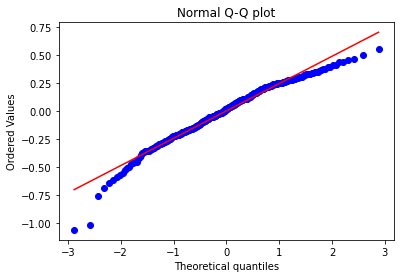

In [110]:
stats.probplot(ridge_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show() 

In [72]:
ridge_2_pred = ridge_model_2.predict(X_test)
print(f'RMSE: {sqrt(mean_squared_error(y_test, ridge_2_pred))}')
print(f'MAE: {mean_absolute_error(y_test, ridge_2_pred)}')

RMSE: 0.060248884803018855
MAE: 0.19555858177941277


### OLS CHARTS FOR P-VALUES!!

In [ ]:
#

### EDA exploration:

In [ ]:
sns.pairplot(all_df,plot_kws=dict(alpha=.10))

In [ ]:
plt.scatter(all_df["Average_Team_Height"],all_df["Average_Team_Weight"],alpha=.1)

In [ ]:
plt.scatter(all_df["Average_Team_Age"],all_df["Average_Years_Play"])

In [ ]:
yearly_df = df.groupby("Year").Total_Adj_Team_Salary.mean()
yearly_weight_df = df.groupby("Year").Average_Team_Weight.mean()
yearly_height_df = df.groupby("Year").Average_Team_Height.mean()
yearly_exp_df = df.groupby("Year").Average_Years_Play.mean()
yearly_age_df = df.groupby("Year").Average_Team_Age.mean()

In [ ]:
fig = plt.figure(figsize=(15,5))
#plt.title("Average Aggregates by Team")
plt.subplot(1,5,1)
plt.plot(yearly_df)
plt.ylabel("In Hundred Millions")
plt.title("Payroll")
#plt.xticks(np.arange(70,77,2))
#plt.yticks(np.arange(170,260,20))
plt.subplot(1,5,2)
plt.plot(yearly_weight_df)
plt.ylabel("In Lbs")
plt.title("Weight")
#plt.xticks(np.arange(70,77,2))
#plt.yticks(np.arange(170,260,20))
plt.subplot(1,5,3)
plt.plot(yearly_height_df)
plt.ylabel("In Inches")
plt.title("Height")
#plt.xticks(np.arange(70,77,2))
#plt.yticks(np.arange(170,260,20))
plt.subplot(1,5,4)
plt.plot(yearly_exp_df)
plt.ylabel("In Years")
plt.title("Playing Experience")
plt.subplot(1,5,5)
plt.plot(yearly_age_df)
plt.ylabel("In Years")
plt.title("Age")
plt.tight_layout()

In [ ]:
plt.subplot(1,3,1)
plt.scatter(all_df["Average_Team_Height"],all_df["Average_Team_Weight"],alpha=.10)
plt.title("All")
plt.subplot(1,3,2)
plt.scatter(bat_df["Average_Height_of_Batter"],bat_df["Average_Weight_of_Batter"],alpha=.10)
plt.title("Batting")
plt.subplot(1,3,3)
plt.scatter(pitch_df["Average_Height_of_Pitcher"],pitch_df["Average_Weight_of_Pitcher"],alpha=.10)
plt.title("Pitching")
plt.tight_layout()

In [ ]:
plt.subplot(1,3,1)
plt.scatter(all_df["Average_Team_Height"],all_df["Average_Team_Weight"],alpha=.05)
plt.title("Combined")
plt.xticks(np.arange(70,77,2))
plt.yticks(np.arange(170,260,20))
plt.subplot(1,3,2)
plt.scatter(bat_df["Average_Height_of_Batter"],bat_df["Average_Weight_of_Batter"],alpha=.05)
plt.title("Batting")
plt.xticks(np.arange(70,77,2))
plt.yticks(np.arange(170,260,20))
#plt.figure(figsize=(2,2))
plt.subplot(1,3,3)
plt.scatter(pitch_df["Average_Height_of_Pitcher"],pitch_df["Average_Weight_of_Pitcher"],alpha=.05)
plt.title("Pitching")
plt.xticks(np.arange(70,77,2))
plt.yticks(np.arange(170,260,20))
#plt.figure(figsize=(2,2))
plt.tight_layout()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(yearly_df,
                            model='additive',
                            period = 1)
fig = result.plot()

In [ ]:
#result_2 = seasonal_decompose(yearly_weight_df,
#                            model='additive',
#                            period = 1)
#fig = result_2.plot()